# Explaining AWD-LSTM predictions using Integrated Gradients

Michal Mucha

**Work based on:**
> Integrated Gradients paper https://arxiv.org/abs/1703.01365.pdf  
Captum implementation & tutorial https://captum.ai/tutorials/IMDB_TorchText_Interpret


> AWD-LSTM paper https://arxiv.org/abs/1708.02182  
fast.ai implementation & training https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb

Thank you to Josh Casswell and Sascha Hoffman for being part of our London fast.ai study group sessions and providing valuable feedback.

**Objective**  

* Understand and sense-check model decision making through inspecting attributions
* Visualize token attributions 
* Provide easy to use code so that anyone can apply this to their fastai-trained models

**Integrated gradients**

In a grand TL;DR  
how much influence on model decision does this input have, 
as compared to baseline input (think blank image vs. actual image)

the actual image is gradually faded in from 0% to 100%  
gradients are calculated for each step on the way  
they are integrated over the [0% to 100%] range and that gives us attributions

as images are naturally easy represent as a continuous domain (float pixel/channel intensity values), they can be scaled from 0 to 100%  

This will not work for discrete token identifier integers. For that reason, we're comparing token embeddings.  
Some ideas for a textual baseline: a zero-embedding vector, or a neutral token

**Illustration:**  
Input = Homer  
Baseline = Hedge fence  
Gradients are calculated at every step from 100% visible to 0% visible  
Attribution value = numerical integration over gradients times alpha as it's going from 0% to 100%  
![](homer-fading.gif)

in other words:  
![](IG_eq1.png)[source](https://captum.ai/docs/algorithms###Integrated-Gradients)  
where  
`x'` - baseline - homer hidden in hedge fence  
`x` - input - homer revealed

integration over `ɑ` - integration over gradients of homer at all steps from visible to invisible

`i` in $x_i$ denotes individual pixels of the input.

In textual examples, it refers to tokens. (Technically, to token embedding vectors)

**AWD-LSTM**

The model architecture is not trivial and leaves the model many ways to learn relationships between input and output. Especially the RNN architecture provides way to learn very sophisticated interactions between elements in a sequence.

Applying IG to this is very enjoyable as it enables you to have sort of a conversation with the model and see the world through it's eyes.

```python 
>>> awd.model
SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(60000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=50, out_features=2, bias=True)
    )
  )
)
```

---

> **Note: for this to work, your model needs to be on the CPU, as the RNN layers backwards propagation in CUDA is implemented only for training mode.**

---

The example pre-trained classifier is created by going thorugh fast.ai lesson 3, creating the learner, and saving it with the  `learn.export()` method. I kept it in the same directory as the notebook, filename `imdb_fastai_trained_lm_clf.pth`

In [1]:
import torch
import torch.nn as nn
import fastai.train
import pandas as pd
from captum.attr import LayerIntegratedGradients

Load a fast.ai `Learner` trained to predict IMDB review category `[negative, positive]`

In [2]:
awd = fastai.train.load_learner('.','imdb_fastai_trained_lm_clf.pth')

/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the 

#### canonical prediction using fastai api

In [3]:
review = 'Incredible performance'
awd.predict(review)

(Category pos, tensor(1), tensor([0.0064, 0.9936]))

#### examine input and output

In [4]:
example_input_tokens = torch.tensor([[5,5,5,5,5]])

In [5]:
prediction = awd.model(example_input_tokens)
prediction

(tensor([[-1.0555,  1.3931]], grad_fn=<AddmmBackward>),
 [tensor([[[ 0.0155, -0.0068, -0.0033,  ...,  0.0090, -0.0150,  0.0164],
           [ 0.0180, -0.0021, -0.0012,  ...,  0.0368, -0.0062,  0.0045],
           [ 0.0257, -0.0014, -0.0009,  ...,  0.0661, -0.0028,  0.0020],
           [ 0.0448, -0.0010, -0.0009,  ...,  0.0621, -0.0020,  0.0015],
           [ 0.0650, -0.0012, -0.0011,  ...,  0.0484, -0.0019,  0.0017]]]),
  tensor([[[-0.0262, -0.0011, -0.0065,  ...,  0.0008,  0.0572,  0.0049],
           [-0.0131, -0.0004, -0.0066,  ...,  0.0002,  0.0578,  0.0122],
           [-0.0115, -0.0003, -0.0059,  ...,  0.0002,  0.0426,  0.0136],
           [-0.0182, -0.0005, -0.0060,  ...,  0.0002,  0.0452,  0.0140],
           [-0.0237, -0.0009, -0.0056,  ...,  0.0002,  0.0533,  0.0141]]]),
  tensor([[[ 0.2700,  0.0318, -0.1369,  ...,  0.1026, -0.1316,  0.0033],
           [ 0.3259,  0.0075, -0.1707,  ...,  0.0963, -0.0292, -0.0096],
           [ 0.2806,  0.0298, -0.1956,  ...,  0.0934, -0.0543,

fastai API `.predict()` call packages up the output into a nice box ready to serve.  
The underlying torch model returns a tuple with the final linear layer, and what appears to be outputs of the 3 RNN layers of the encoder.  
As the RNN layers correspond in length to the input sequence (obviously), they can be used to derive gradient based explanations as well.

In [6]:
prediction = prediction[0]
prediction

tensor([[-1.0555,  1.3931]], grad_fn=<AddmmBackward>)

The underlying model does not apply the final activation function, so let's apply it below:

In [7]:
torch.softmax(prediction, dim=-1)

tensor([[0.0795, 0.9205]], grad_fn=<SoftmaxBackward>)

#### Preparing input

this prepares a mini-batch of 1, both `x` and `y`  
`y` is a dummy label value, not necessary

In [8]:
x, y = awd.data.one_item(review)
x

tensor([[   2,    5, 1127,  261]])

In [9]:
vocab = awd.data.x.vocab

reversed tokens

In [10]:
[vocab.itos[token] for token in x[0]]

['xxbos', 'xxmaj', 'incredible', 'performance']

### Preparing the model for integrated gradients

we will need `1)` the embedding layer*, and `2)` the complete forward pass (all the way through to post-softmax predictions)

_*note that we can use any of the RNN layer outputs instead of the initial embedding layer_

the fast.ai AWD LSTM implementation does not work directly with captum, as the embeddings hook needs to grab the correct layer. This does not happen automatically and we need to dig into the model structure to find the layer.

It appears as if there's duplication, but in reality those are nested modules, and the reason for that is the custom embeddings dropout implemented by the fast.ai team. There is also more engineering involved with varying learning rates for better training, which I have not examined.

```Python
>>> awd.model
SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(60000, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(               # <- this is the one!
        (emb): Embedding(60000, 400, padding_idx=1)
      )
      (rnns): ModuleList(
...
```

The model is built from an encoder and a classifier head.  
`awd.model[0]` gives us the encoder  
`._modules['module']` grabs the MultiBatchEncoder part  
`._modules['encoder_dp']` grabs the EmbeddingDropout module

In [11]:
embedding_layer = awd.model[0]._modules['module']._modules['encoder_dp']
embedding_layer(example_input_tokens).shape

torch.Size([1, 5, 400])

shape checks out

Forward pass needs to go all the way through to the final verdict, and not return any extra data such as the hidden state.

In [12]:
forward_func = lambda x: torch.softmax(awd.model(x)[0], dim=-1)

In [13]:
lig = LayerIntegratedGradients(
    forward_func, 
    embedding_layer
)

### Apply IG to an example sentence

#### Input

In [14]:
sentence = 'Best film ever'
sentence_tokens = awd.data.one_item(sentence)[0]
sentence_tokens

tensor([[  2,   5, 140,  32, 145]])

In [15]:
reversed_tokens = [vocab.itos[t] for t in sentence_tokens[0]]
reversed_tokens

['xxbos', 'xxmaj', 'best', 'film', 'ever']

#### Baseline

The key principle of IG is to understand the impact of the actual input as compared to a baseline.

The choice of baseline matters very much, it is intended to be _"blank input"_. The authors give the example of a blank image, black pixels (RGB value 0,0,0).

The method works by increasingly introducing input, from 0% to 100%, and calculating gradients along the way. At the end of the procedure, integration over the [0%, 100%] space is applied to get an attribution value that fulfils the axioms.
(It's very well explained in [the paper](https://arxiv.org/pdf/1703.01365.pdf))

For that reason, the choice of baseline is important. Using a wrong baseline can produce the results that make the algorithm look drunk, and give no value.

In [16]:
vocab.itos[:7]

['xxunk', 'xxpad', 'xxbos', 'xxeos', 'xxfld', 'xxmaj', 'xxup']

In [17]:
baseline = torch.zeros_like(sentence_tokens)
baseline[0, 0] = 2
baseline

tensor([[2, 0, 0, 0, 0]])

The first token in each input generated by the fast.ai text preprocessor is `xxbos`, as in "beginning of sentence". I want the baseline to start with `xxbos` as well. I'm using `xxunk` for the rest, just to try if it works. More on the choice of baseline later.

#### Get attributions

In [18]:
attrs = lig.attribute(sentence_tokens, baseline, 1, n_steps=200)
attrs.shape

torch.Size([1, 5, 400])

sum gradients over the embedding dimension (400) and end up with one value per token

In [19]:
attrs.sum(-1)

tensor([[ 0.0000, -0.2337,  0.4169,  0.0464,  0.0865]], dtype=torch.float64)

total non-normalized attribution across tokens

In [20]:
attrs.sum()

tensor(0.3161, dtype=torch.float64)

normalized attributions

In [21]:
a = attrs.sum(-1)
a = a / torch.norm(a)
a

tensor([[ 0.0000, -0.4790,  0.8545,  0.0950,  0.1773]], dtype=torch.float64)

In [22]:
a.sum()

tensor(0.6478, dtype=torch.float64)

plot of attributions

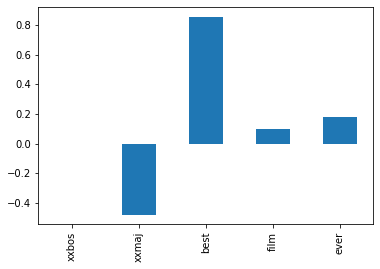

In [23]:
pd.Series(a.numpy()[0], index=reversed_tokens).plot.bar()

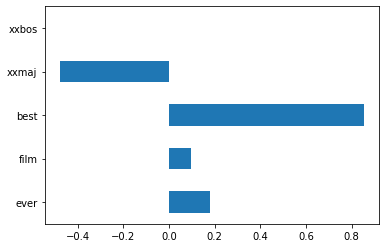

In [24]:
pd.Series(a.numpy()[0], index=reversed_tokens).iloc[::-1].plot.barh()

> remember, those are token-wise attributions **relative to baseline!**

### What makes a good baseline?

One approach would be to create a zero-embedding vector. In this scenario, we would need to apply embeddings outside of the model and feed already-embedded tokens in.

For a quick prototype, we'll look at some of the tokens as they are, and try to find one that gives indecisive, neutral predictions.

Let's look for low influence on prediction among the initial tokens.  
The vocabulary is constructed by order of value counts, but the first couple tokens are always the "chassis" semantics of the data format, to help the model make proper distinctions relevant to things that are obvious to model creators.

In [25]:
print('i', f'{"TOK":7s}', '\t', f'{str("PRED"):15s}', '\t', f'{"L-R":.4s}', '\t\tX for < .1')
for i, tok in enumerate(awd.data.x.vocab.itos[:40]):
    pred = awd.model(torch.tensor([[2] + [i]*8]))[0]
    pred = torch.softmax(pred, dim=-1)
    pred = pred.detach().numpy().round(4)[0]
    diff = pred[1]-pred[0]
    print(i, f'{tok.__repr__():7s}', '\t', f'{str(pred):15s}', '\t', f'{diff:.4f}', '\tx' if abs(diff)<.1 else '')

i TOK     	 PRED            	 L-R 		X for < .1
0 'xxunk' 	 [0.6021 0.3979] 	 -0.2042 
1 'xxpad' 	 [0.3843 0.6157] 	 0.2314 
2 'xxbos' 	 [0.1002 0.8998] 	 0.7996 
3 'xxeos' 	 [0.9085 0.0915] 	 -0.8170 
4 'xxfld' 	 [0.9085 0.0915] 	 -0.8170 
5 'xxmaj' 	 [0.0142 0.9858] 	 0.9716 
6 'xxup'  	 [0.3182 0.6818] 	 0.3636 
7 'xxrep' 	 [0.088 0.912]   	 0.8240 
8 'xxwrep' 	 [5.000e-04 9.995e-01] 	 0.9990 
9 'the'   	 [0.2766 0.7234] 	 0.4468 
10 '.'     	 [0.1513 0.8487] 	 0.6974 
11 ','     	 [0.0095 0.9905] 	 0.9810 
12 'and'   	 [0. 1.]         	 1.0000 
13 'a'     	 [0.2772 0.7228] 	 0.4456 
14 'of'    	 [0.0743 0.9257] 	 0.8514 
15 'to'    	 [0. 1.]         	 1.0000 
16 'is'    	 [0.06 0.94]     	 0.8800 
17 'it'    	 [4.000e-04 9.996e-01] 	 0.9992 
18 'in'    	 [0.0465 0.9535] 	 0.9070 
19 'i'     	 [0.0108 0.9892] 	 0.9784 
20 'this'  	 [1.000e-04 9.999e-01] 	 0.9998 
21 'that'  	 [2.000e-04 9.998e-01] 	 0.9996 
22 '"'     	 [0.02 0.98]     	 0.9600 
23 "'s"    	 [0.0019 0.9981] 	 0.9962 

**because every example starts with xxbos**  

> `\n \n ` seems the only neutral option  
in practice I've seen good results with `.` as well  
not with `xxeos` or `xxfld`

when generating the same table and **not starting with mandatory 'xxbos',**  

> `.` and `xxeos` and `xxfld` and `"` seem good candidates  
because they produce close to 0 impact on prediction (with the approach taken above)

**note after practice:**  
> * turns out `xxbos` padding throughout makes a more neutral performance than `xxfld` `xxeos` in negative target, bit confusing in positive target
> * `.` (dot) seems to provide neutrality in various cases I tried

**token meanings from [forums](https://forums.fast.ai/t/xxbos-is-it-marking-beginning-of-sentence-or-beginning-of-text/43688/4):**


        UNK (xxunk) is for an unknown word (one that isn’t present in the current vocabulary)
        BOS (xxbos) represents the beginning of a text in your dataset
        FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor 1 to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
        TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text
        TK_UP (xxup) is used to indicate the next word is written in all caps in the original text
        TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})
        TK_WREP (xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})



### Wrap code into a `get_attributions_for_sentence` function

In [62]:
awd = fastai.train.load_learner(path='.', file='imdb_fastai_trained_lm_clf.pth')

/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.loss.CrossEntropyLoss' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the 

In [63]:
awd.model[0].bptt = 1000

In [64]:
awd.model[0].bptt

1000

In [65]:
# getting to the actual layer that holds embeddings
embedding_layer = awd.model[0]._modules['module']._modules['encoder_dp']

# working around the model prediction - first output only, apply softmax
forward_func = lambda x: torch.softmax(awd.model(x)[0], dim=-1)

In [66]:
# make integrated gradients instance
lig = LayerIntegratedGradients(
    forward_func, 
    embedding_layer
)

In [67]:
def get_attributions_for_sentence(sentence = 'Best film ever', 
                                  awd_model=awd, 
                                  lig_instance=lig,
                                  target = None, 
                                  lig_n_steps = 100,
                                  baseline_token='.'):
    awd = awd_model
    lig = lig_instance
    vocab = awd.data.x.vocab
    sentence_tokens = awd.data.one_item(sentence)[0]
    reversed_tokens = [vocab.itos[w] for w in sentence_tokens[0]]
    baseline = torch.ones_like(sentence_tokens) * vocab.stoi[baseline_token] # see "how to choose a good baseline"
    baseline[0,0] = vocab.stoi['xxbos'] # beginning of sentence is always #1
    y = awd.predict(sentence)
    if target is None:
        target = y[1].item()
    attrs = lig.attribute(sentence_tokens, baseline, target, n_steps=lig_n_steps)
    a = attrs.sum(-1)
    a = a / torch.norm(a)
    return (
        pd.Series(a.numpy()[0], index=reversed_tokens),
        y
    )

#### try it

(0.7473038122054388, (Category neg, tensor(0), tensor([0.6452, 0.3548])))

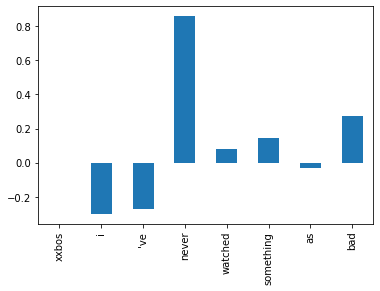

In [68]:
a, y = get_attributions_for_sentence('I\'ve never watched something as bad')
a.plot.bar()
a.sum(), y 

reversed target:

(-0.7473037792994757, (Category neg, tensor(0), tensor([0.6452, 0.3548])))

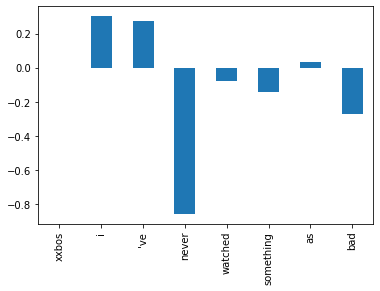

In [32]:
a, y = get_attributions_for_sentence('I\'ve never watched something as bad', target=1)
a.plot.bar()
a.sum(), y 

#### with a different baseline token

(0.5969958662970067, (Category neg, tensor(0), tensor([0.7552, 0.2448])))

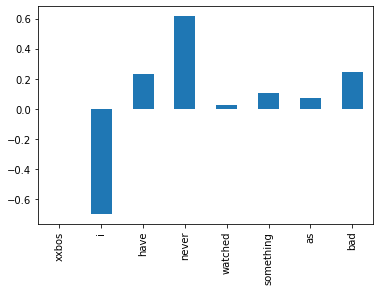

In [33]:
a, y = get_attributions_for_sentence(r'I have never watched something as bad', 
                                     baseline_token='\n \n ')
a.plot.bar()
a.sum(), y 

reversed target

(-0.596995870050405, (Category neg, tensor(0), tensor([0.7552, 0.2448])))

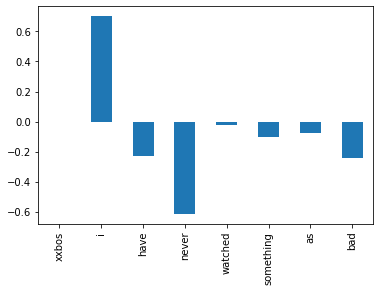

In [34]:
a, y = get_attributions_for_sentence('I have never watched something as bad', 
                                     target=1, baseline_token='\n \n ')
a.plot.bar()
a.sum(), y 

#### another example

(1.3902248757295699, (Category pos, tensor(1), tensor([0.0019, 0.9981])))

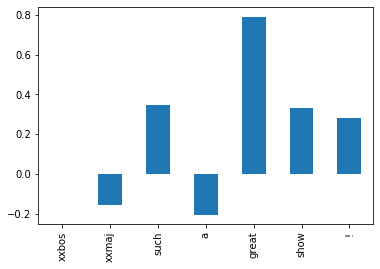

In [35]:
a, y = get_attributions_for_sentence('Such a great show!')
a.plot.bar()
a.sum(), y 

reversed target

(-1.3902248571469171, (Category pos, tensor(1), tensor([0.0019, 0.9981])))

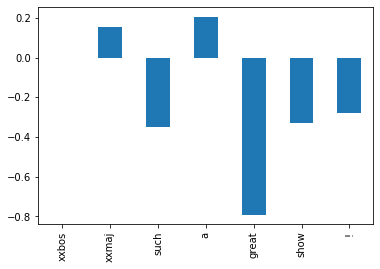

In [36]:
a, y = get_attributions_for_sentence('Such a great show!', target=0)
a.plot.bar()
a.sum(), y 

(1.8880242934243174, (Category pos, tensor(1), tensor([0.0019, 0.9981])))

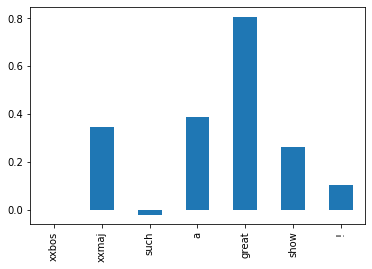

In [37]:
a, y = get_attributions_for_sentence('Such a great show!', target=1, baseline_token='\n \n ')
a.plot.bar()
a.sum(), y 

> prediction live in call

#### Sarcastic 1 star review of the film "Cats".  

(-0.6082090966551856, (Category pos, tensor(1), tensor([0.2470, 0.7530])))

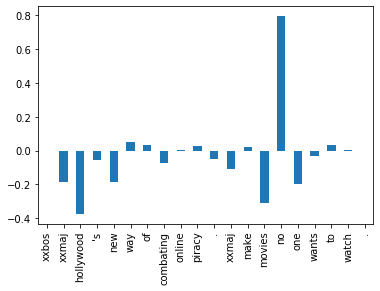

In [38]:
review = r"Hollywood's new way of combating online piracy. Make movies no one wants to watch."

a, y = get_attributions_for_sentence(review, target=0, baseline_token='\n \n ')

a.plot.bar()
a.sum(), y 

The model doesn't get it.  
The negative attributions tell us that
`Hollywood` `'s` `new` `combating` `movies` `one` are what differentiates this sentence from baseline.

The word `no` seems to be the only indicator tilting the prediction in the correct direction.  
That makes sense - this is the punch line - "no one wants to watch"

#### 10 star review of the film Parasite

Review:
I am remarkably stingy with my 10/10 ratings. I'll be the first person to acknowledge this. Of the roughly 2600 titles I've rated on here, only 34 have a 10. Parasite is one of them. If this isn't a masterpiece, then I don't know what is.

Prediction: (Category pos, tensor(1), tensor([0.2338, 0.7662]))
Sum of attributions: 1.152911045947124


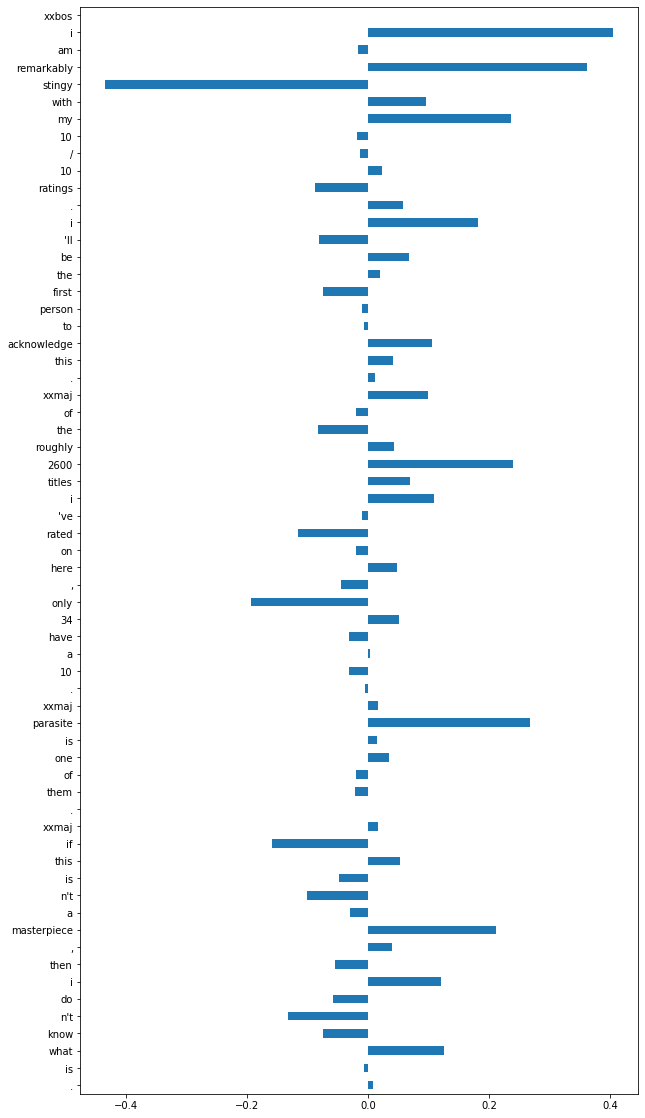

In [39]:
review = r"I am remarkably stingy with my 10/10 ratings. I'll be the first person to acknowledge this. Of the roughly 2600 titles I've rated on here, only 34 have a 10. Parasite is one of them. If this isn't a masterpiece, then I don't know what is."
a, y = get_attributions_for_sentence(review, target=1, baseline_token='\n \n ')
print(f'Review:\n{review}\n')
print('Prediction:', y)
print('Sum of attributions:', a.sum())
a.iloc[::-1].plot.barh(figsize=(10,20));

This time the model gets it.

Interesting observations:

* subjective `I` appears as a positive influence multiple times. It could well mean that the use of `I` signals people have personal feelings and opinions, and relating the subject of review to themselves means they view it positively (hat tip to Josh for this interpretation)
* capitalization by itself seems to be a positive factor - `xxmaj` or the next token after it get a positive attribution score

In [40]:
a.sort_values(ascending=False).head(7)

i              0.404297
remarkably     0.362786
parasite       0.266965
2600           0.240347
my             0.235565
masterpiece    0.211457
i              0.181278
dtype: float64

In [41]:
a.sort_values(ascending=True).head()

stingy   -0.434922
only     -0.193789
if       -0.159791
n't      -0.132368
rated    -0.116018
dtype: float64

### fin

In [42]:
review = r""" 
Bernie Sanders, the progressive whose two campaigns for president pulled the Democratic Party to the left, ended his White House bid Wednesday, leaving former Vice President Joe Biden as the party’s presumptive nominee for the 2020 election.
“The path toward victory is virtually impossible,” Mr. Sanders said in a livestreamed address. “If I believed that we had a feasible path to the nomination, I would certainly continue the campaign. But it’s just not there.”
"""

In [75]:
review = r""" 
Has there ever been a bad performance in a Guy Ritchie movie? If there has I haven't noticed it. He has an ornate ability to take average actors and make them great, and to take already great actors and get even more out of them. There are a few directors around who specialise in this but Ritchie is right near the top. The cast in 'The Gentlemen' is admittedly fantastic, but it doesn't change the fact that they are an absolute treat to watch. Matthew McConaughey is in his element in a role that he was born to play, Charlie Hunnam plays one of the coolest characters I've seen perfectly, Colin Farrell is hilarious and ridiculously cool as well and then Hugh Grant gives one of the best performances I've ever seen from him. In fact Grant was so good I didn't even recognise his voice and had to wonder if they'd dubbed it. They hadn't, he'd just nailed it.

The style this movie possesses is just so much fun to watch. If you've seen any of Ritchie's previous similar films ('Lock, Stock and Two Smoking Barrels', 'Snatch', 'RocknRolla') then you know what I'm talking about. The pacing moves at lightning speed, the dialogue is quick, clever and deeper than you first realise and the conflict is always multi-layered. This one is actually told in quite a unique way with a couple of characters going over events that have already happened and it works masterfully. It breaks the story up and gives room for creativity in the story-telling process and also humour.

Every time I see that Ritchie has made a movie that isn't a crime-thriller I get a little disappointed. It's not that the other stuff he's doing is bad ('Swept Away' being an obvious exception), it's just that he is so damn good as this style of movie. He's the best in the business and if he only did these for the rest of his career I'd be a very happy man. This is an excellent movie well worth your time and money.
"""

In [54]:
awd.model[0].bptt

70

In [76]:
review_tokens = awd.data.one_item(review)[0]

In [77]:
review_tokens.shape

torch.Size([1, 454])

In [ ]:
a, y = get_attributions_for_sentence(review, target=1, baseline_token='\n \n ')
print(f'Review:\n{review}\n')
print('Prediction:', y)
print('Sum of attributions:', a.sum())
a.iloc[::-1].plot.barh(figsize=(10,30));

In [80]:
a.nlargest(10)

xxunk        0.211851
colin        0.203495
swept        0.185936
.            0.174086
snatch       0.164407
worth        0.138396
and          0.137426
excellent    0.115905
xxmaj        0.108830
well         0.108700
dtype: float64

In [81]:
a.nsmallest(10)

lock           -0.379606
bad            -0.199201
ever           -0.185545
hugh           -0.184291
ridiculously   -0.171692
ritchie        -0.147848
xxunk          -0.137478
few            -0.118859
bad            -0.113984
there          -0.110625
dtype: float64

In [98]:
class MyClass:
    a = 10
    
    def __repr__(self):
        return self.__class__.__name__ + str(self.a)
    
    def _repr_html_(self):
        return "<h2>" + self.__class__.__name__ + str(self.a) + "</h2>"

In [96]:
x = MyClass()

In [97]:
x

MyClass10